In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from scipy.optimize import minimize


import plotly as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dateutil

import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [ ]:
# CPI Graph

df_cpi = pd.read_csv("cpi-data.csv")
df_cpi['DATE'] = pd.to_datetime(df_cpi['DATE'], format='%Y-%m-%d')
df_cpi["CPI_change"] =  df_cpi["CPIAUCSL"].pct_change(12)*100
df_cpi = df_cpi[(df_cpi['DATE'] >= '2000-01-01') & (df_cpi['DATE'] <= '2024-01-01')]

fig = make_subplots(specs=[[{"secondary_y": False}]])

fig.add_trace(
    go.Scatter(x=df_cpi['DATE'], y=df_cpi["CPI_change"], name="CPI"),
    secondary_y=False,
)

fig.update_layout(
    title_text="Annual CPI % Change (2000 to 2024)",
    font=dict(
        size=18,
    )
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="CPI Percentage Change", secondary_y=False)

fig.show()

In [ ]:
# Market Volatility Indicator

df_MVI = pd.read_csv("market-volatility.csv")
df_MVI['DATE'] = pd.to_datetime(df_MVI['DATE'], format='%Y-%m-%d')
df_MVI = df_MVI[(df_MVI['DATE'] >= '2000-01-01') & (df_MVI['DATE'] <= '2024-01-01')]

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=df_MVI['DATE'], y=df_MVI["EMVMACROCONSUME"], name="MVI"),
    secondary_y=True,
)

fig.update_layout(
    title_text="Market Volatility Indicator (2000 to 2022)",
    font=dict(
        size=18,
    )
)

fig.update_xaxes(title_text="Date")

fig.update_yaxes(title_text="Placeholder", secondary_y=False)
fig.update_yaxes(title_text="Market Volatility Index", secondary_y=True)

fig.show()

In [ ]:
df_gdp = pd.read_csv("GDP.csv")

df_gdp['DATE'] = pd.to_datetime(df_gdp['DATE'], format='%Y-%m-%d')

df_gdp['Year'] = df_gdp['DATE'].dt.year
annual_avg_gdp = df_gdp.groupby('Year')['GDP'].mean().reset_index()

annual_avg_gdp = annual_avg_gdp[(annual_avg_gdp['Year'] >= 2000) & (annual_avg_gdp['Year'] <= 2024)]

fig = make_subplots(specs=[[{"secondary_y": False}]])

fig.add_trace(
    go.Scatter(x=annual_avg_gdp['Year'], y=annual_avg_gdp['GDP'], name="Average GDP", mode='lines+markers'),
    secondary_y=False,
)

fig.update_layout(
    title_text="Average Annual GDP (2000 to 2024)",
    font=dict(
        size=18,
    )
)

fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Average GDP (in billions)", secondary_y=False)

fig.show()

In [ ]:
df_interest = pd.read_csv("ir.csv")

df_interest['DATE'] = pd.to_datetime(df_interest['DATE'], format='%Y-%m-%d')

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_interest['DATE'],
        y=df_interest['REAINTRATREARAT10Y'],
        mode='lines+markers',
        name='Interest Rate (10Y)',
        line=dict(color='green')
    )
)

fig.update_layout(
    title="Interest Rates Over Time (10-Year)",
    xaxis_title="Date",
    yaxis_title="Interest Rate (%)",
    font=dict(size=14),
    height=500,
    width=900
)

In [ ]:
fomc_data = pd.read_csv("market_trust_stability_labels.csv")
ir_data = pd.read_csv("ir.csv")

fomc_data['year'] = fomc_data['year']
fomc_aggregated = fomc_data.groupby('year').agg(
    hawkish=('pred_labels', lambda x: (x == 1).sum()),
    dovish=('pred_labels', lambda x: (x == 0).sum()),
    neutral=('pred_labels', lambda x: (x == 2).sum()),
    trust=('pred_labels_trust', lambda x: (x == 1).sum()),
    mistrust=('pred_labels_trust', lambda x: (x == 0).sum()),
    neutral_trust=('pred_labels_trust', lambda x: (x == 2).sum()),
    stable=('pred_labels_stability', lambda x: (x == 1).sum()),
    volatile=('pred_labels_stability', lambda x: (x == 0).sum()),
    no_effect=('pred_labels_stability', lambda x: (x == 2).sum())
)

fomc_aggregated['total'] = fomc_aggregated[['hawkish', 'dovish', 'neutral']].sum(axis=1)

ir_data['DATE'] = pd.to_datetime(ir_data['DATE'])
ir_data['year'] = ir_data['DATE'].dt.year
ir_yearly = ir_data.groupby('year').agg(avg_interest_rate=('REAINTRATREARAT10Y', 'mean')).reset_index()

data = pd.merge(fomc_aggregated, ir_yearly, on='year', how='right').fillna(0)

def calculate_measure(data, weights):
    hawkish_weight, trust_weight, volatile_weight = weights
    measure = (
        hawkish_weight * (data['hawkish'] - data['dovish']) / data['total'] +
        trust_weight * data['trust'] / data['total'] -
        volatile_weight * data['volatile'] / data['total']
    )

    data['measure'] = (
        hawkish_weight * (data['hawkish'] - data['dovish']) / data['total'] +
        trust_weight * data['trust'] / data['total'] -
        volatile_weight * data['volatile'] / data['total']
    )

    measure_min, measure_max = data['measure'].min(), data['measure'].max()
    rate_min, rate_max = data['avg_interest_rate'].min(), data['avg_interest_rate'].max()

    data['measure_normalized'] = ((data['measure'] - measure_min) / (measure_max - measure_min)) * 0.5 * (rate_max - rate_min) + rate_min
    measure = measure.fillna(0)
    return measure

def objective(weights):
    data['measure'] = calculate_measure(data, weights)
    error = ((data['measure'] - data['avg_interest_rate'])**2).mean()
    # print(f"w= {weights}, e = {error}")
    return error

initial_weights = [1.0, 1.0, 1.0]

result = minimize(objective, initial_weights, bounds=[(0, None), (0, None), (0, None)])
optimized_weights = result.x

print(f"Optimized Weights: {optimized_weights}")

data['final_measure'] = calculate_measure(data, optimized_weights)

# print(data[['year', 'hawkish', 'dovish', 'total', 'measure', 'avg_interest_rate']].head())

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=data['year'],
        y=data['avg_interest_rate'],
        name="Interest Rate (10Y)",
        mode="lines+markers",
        line=dict(color="blue")
    )
)

fig.add_trace(
    go.Scatter(
        x=data['year'],
        y= 0.9 * data['final_measure'] + 0.75,
        name="Final Measure",
        mode="lines+markers",
        line=dict(color="orange")
    )
)

fig.update_layout(
    title="Interest Rates vs Final Measure (2000 to 2024)",
    xaxis_title="Year",
    yaxis_title="Value",
    font=dict(size=14),
    height=500,
    width=900
)

fig.show()


Optimized Weights: [1.31169443 4.03913879 0.        ]


In [ ]:
hawkish_weight = 0.55
dovish_weight = 0.3
trust_weight = 0.1
volatile_weight = 0.05

data['measure'] = (
    hawkish_weight * (data['hawkish'] - data['dovish']) / data['total'] +
    trust_weight * data['trust'] / data['total'] -
    volatile_weight * data['volatile'] / data['total']
)

# normalization
measure_min, measure_max = data['measure'].min(), data['measure'].max()
rate_min, rate_max = data['avg_interest_rate'].min(), data['avg_interest_rate'].max()

data['measure_normalized'] = ((data['measure'] - measure_min) / (measure_max - measure_min)) * 0.5 * (rate_max - rate_min) + rate_min

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=data['year'],
        y=data['avg_interest_rate'],
        name="Interest Rate (10Y)",
        mode="lines+markers",
        line=dict(color="blue")
    )
)

fig.add_trace(
    go.Scatter(
        x=data['year'],
        y= 0.9 * data['measure_normalized'] + 0.75,
        name="Measure",
        mode="lines+markers",
        line=dict(color="green")
    )
)

fig.update_layout(
    title="Interest Rates vs Optimized Measure (2000 to 2024)",
    xaxis_title="Year",
    yaxis_title="Interest Rate",
    font=dict(size=14),
    height=500,
    width=900
)

fig.show()



In [ ]:
from sklearn.linear_model import LinearRegression

X = data[['hawkish', 'dovish', 'trust', 'volatile']]
y = data['avg_interest_rate']

model = LinearRegression()
model.fit(X, y)

data['predicted_interest_rate'] = model.predict(X)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=data['year'],
        y=data['avg_interest_rate'],
        name="Interest Rate (10Y)",
        mode="lines+markers",
        line=dict(color="blue")
    )
)

fig.add_trace(
    go.Scatter(
        x=data['year'],
        y=data['predicted_interest_rate'],
        name="Predicted Interest Rate",
        mode="lines+markers",
        line=dict(color="green")
    )
)

fig.update_layout(
    title="Actual vs Predicted Interest Rates (2000 to 2024)",
    xaxis_title="Year",
    yaxis_title="Interest Rate",
    font=dict(size=14),
    height=500,
    width=900
)

fig.show()

In [ ]:
# Performance Analysis

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

rmse = mean_squared_error(data['avg_interest_rate'], data['measure_normalized'], squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

mae = mean_absolute_error(data['avg_interest_rate'], data['measure_normalized'])
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE): 1.1843613385193035
Mean Absolute Error (MAE): 0.9394485605887801


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [ ]:
residuals = data['avg_interest_rate'] - data['measure_normalized']
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['year'], y=residuals, mode='markers', name="Residuals"))
fig.update_layout(
    title="Residuals of Measure vs Interest Rate",
    xaxis_title="Year",
    yaxis_title="Residuals"
)
fig.show()

mean_residuals = residuals.mean()
print(mean_residuals)

0.72246110778114


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('hd.csv')

# Basic model performance metrics
accuracy = accuracy_score(df['label'], df['pred_labels'])
conf_matrix = confusion_matrix(df['label'], df['pred_labels'])
class_report = classification_report(df['label'], df['pred_labels'])

# Calculate per-class metrics
class_accuracy = {}
for label in df['label'].unique():
    mask = df['label'] == label
    class_accuracy[label] = accuracy_score(
        df[mask]['label'],
        df[mask]['pred_labels']
    )

# Error analysis
errors = df[df['label'] != df['pred_labels']].copy()
errors['error_type'] = errors.apply(lambda x: f"True: {x['label']} -> Pred: {x['pred_labels']}", axis=1)

# Temporal analysis
yearly_performance = df.groupby('year').apply(
    lambda x: accuracy_score(x['label'], x['pred_labels'])
).to_dict()

# Create confusion matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.close()

# Print detailed results
print("\nModel Performance Evaluation")
print("===========================")
print(f"\nOverall Accuracy: {accuracy:.2%}")

print("\nConfusion Matrix:")
print("Labels: 0 (Dovish), 1 (Neutral), 2 (Hawkish)")
print(conf_matrix)

print("\nDetailed Classification Report:")
print(class_report)

print("\nPer-Class Accuracy:")
for label, acc in class_accuracy.items():
    label_name = {0: "Dovish", 1: "Neutral", 2: "Hawkish"}.get(label, str(label))
    print(f"{label_name}: {acc:.2%}")

print("\nError Analysis:")
print(f"Total errors: {len(errors)}")
print("\nError type distribution:")
for error_type, count in errors['error_type'].value_counts().items():
    print(f"{error_type}: {count}")

print("\nPrediction Distribution:")
print("\nPredicted labels distribution:")
print(df['pred_labels'].value_counts(normalize=True))
print("\nTrue labels distribution:")
print(df['label'].value_counts(normalize=True))

print("\nTemporal Performance:")
for year in sorted(yearly_performance.keys()):
    print(f"Year {year}: {yearly_performance[year]:.2%}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

<ipython-input-79-0969622334b3>:29: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the g


Model Performance Evaluation

Overall Accuracy: 66.40%

Confusion Matrix:
Labels: 0 (Dovish), 1 (Neutral), 2 (Hawkish)
[[   0    0    0    0]
 [   2  686   73  743]
 [   2   86  662  682]
 [   5  200  125 2443]]

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.71      0.46      0.55      1504
           1       0.77      0.46      0.58      1432
           2       0.63      0.88      0.74      2773

    accuracy                           0.66      5709
   macro avg       0.53      0.45      0.47      5709
weighted avg       0.69      0.66      0.65      5709


Per-Class Accuracy:
Dovish: 45.61%
Neutral: 46.23%
Hawkish: 88.10%

Error Analysis:
Total errors: 1918

Error type distribution:
True: 0 -> Pred: 2: 743
True: 1 -> Pred: 2: 682
True: 2 -> Pred: 0: 200
True: 2 -> Pred: 1: 125
True: 1 -> Pred: 0: 86
True: 0 -> Pred: 1: 73
True: 2 -> Pred: -1: 5
True: 1 -> Pred: -1: 2
T

Generating plots...


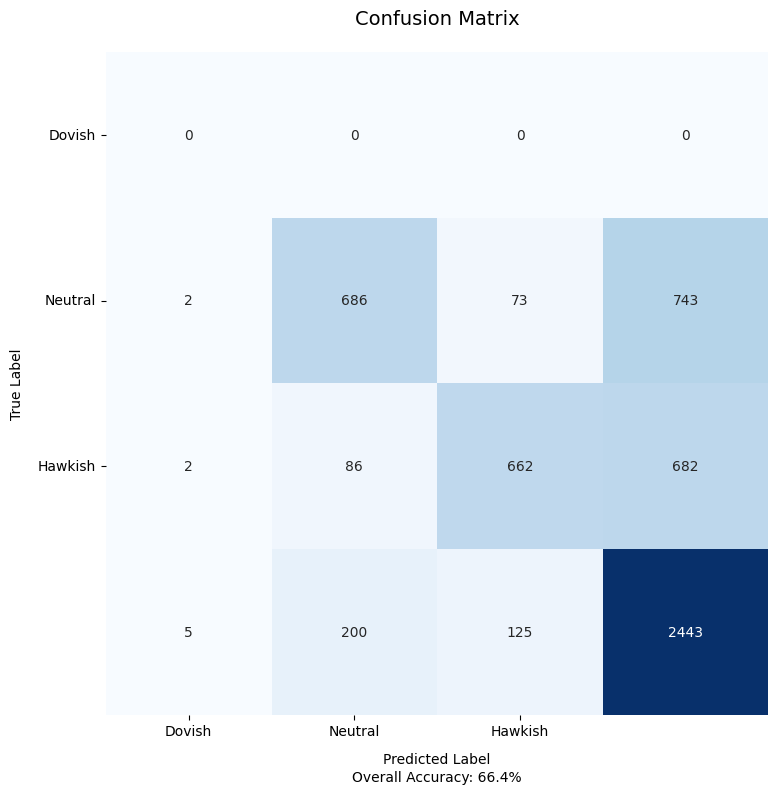

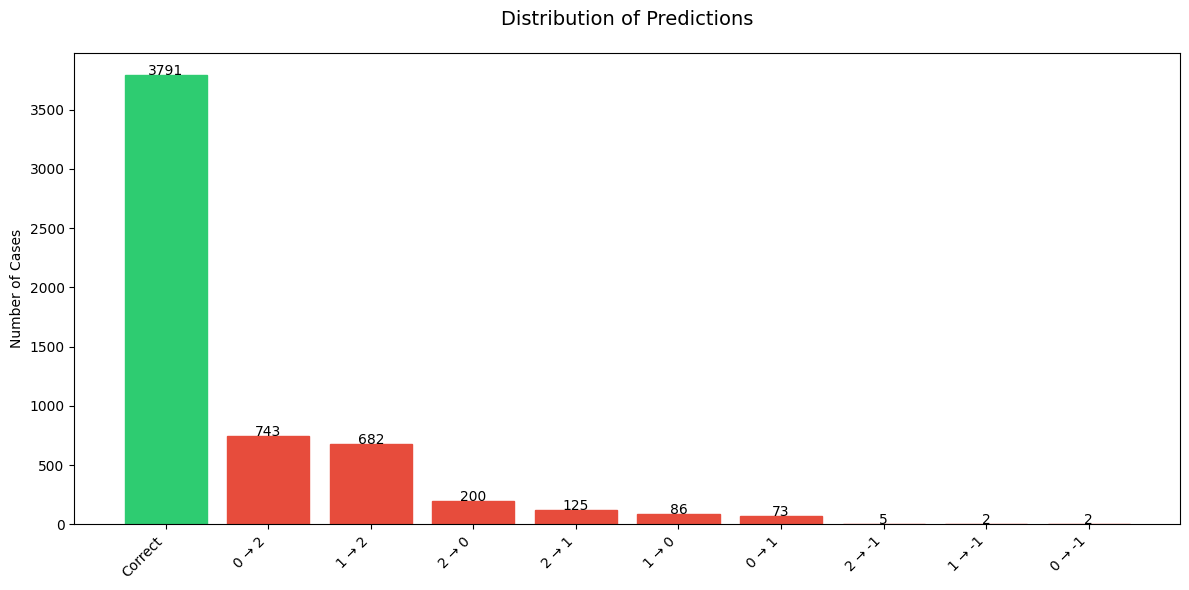

<ipython-input-81-f78a248219cb>:78: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



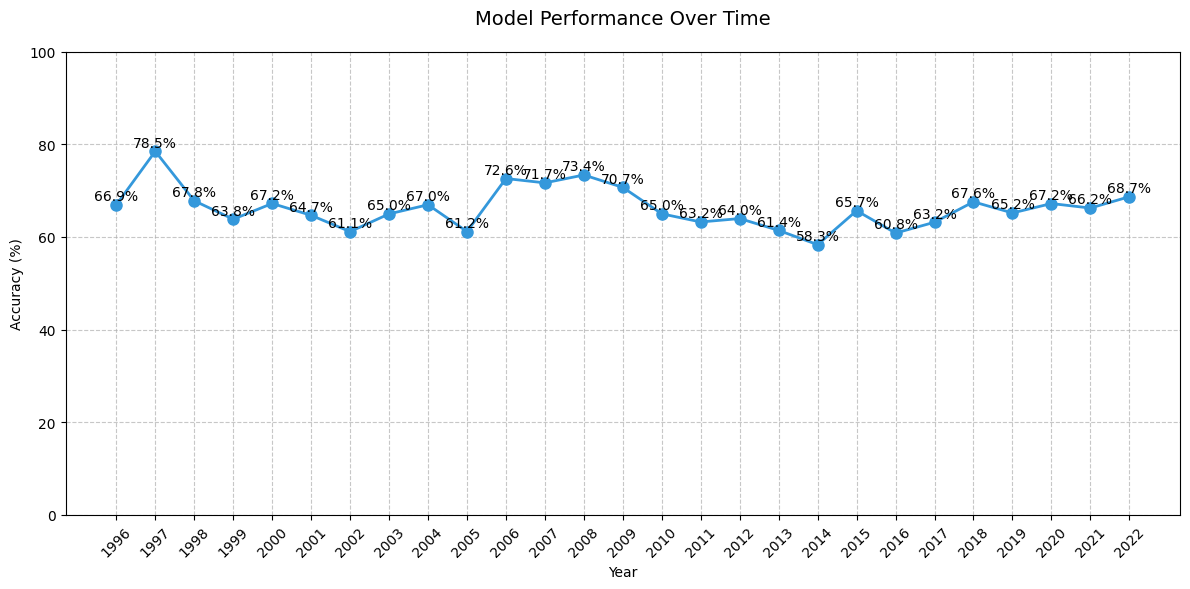

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

df = pd.read_csv('hd.csv')

plt.style.use('default')
colors = ['#2ecc71', '#3498db', '#9b59b6']

def plot_confusion_matrix():
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(df['label'], df['pred_labels'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                square=True, cbar=False)

    label_names = ['Dovish', 'Neutral', 'Hawkish']
    plt.xticks(np.arange(len(label_names)) + 0.5, label_names, rotation=0)
    plt.yticks(np.arange(len(label_names)) + 0.5, label_names, rotation=0)

    plt.title('Confusion Matrix', pad=20, size=14)
    plt.xlabel('Predicted Label', labelpad=10)
    plt.ylabel('True Label', labelpad=10)

    accuracy = (cm.diagonal().sum() / cm.sum()) * 100
    plt.text(0.5, -0.1, f'Overall Accuracy: {accuracy:.1f}%',
             horizontalalignment='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

def plot_error_distribution():
    df['error_type'] = df.apply(
        lambda x: 'Correct' if x['label'] == x['pred_labels']
        else f'{x["label"]} → {x["pred_labels"]}', axis=1
    )

    plt.figure(figsize=(12, 6))

    error_counts = df['error_type'].value_counts()

    bars = plt.bar(range(len(error_counts)), error_counts.values)

    for i, bar in enumerate(bars):
        if error_counts.index[i] == 'Correct':
            bar.set_color('#2ecc71')
        else:
            bar.set_color('#e74c3c')

    plt.title('Distribution of Predictions', pad=20, size=14)
    plt.xticks(range(len(error_counts)), error_counts.index, rotation=45, ha='right')
    plt.ylabel('Number of Cases')

    for i, v in enumerate(error_counts.values):
        plt.text(i, v + 0.5, str(v), ha='center')

    plt.tight_layout()
    plt.show()

def plot_temporal_performance():
    yearly_acc = df.groupby('year').apply(
        lambda x: (x['label'] == x['pred_labels']).mean()
    ).reset_index()
    yearly_acc.columns = ['year', 'accuracy']

    plt.figure(figsize=(12, 6))

    plt.plot(yearly_acc['year'], yearly_acc['accuracy'] * 100,
             marker='o', linewidth=2, markersize=8, color='#3498db')

    for x, y in zip(yearly_acc['year'], yearly_acc['accuracy'] * 100):
        plt.text(x, y + 1, f'{y:.1f}%', ha='center')

    plt.title('Model Performance Over Time', pad=20, size=14)
    plt.xlabel('Year')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(0, 100)

    plt.xticks(yearly_acc['year'], rotation=45)

    plt.tight_layout()
    plt.show()

print("Generating plots...")
plot_confusion_matrix()
plot_error_distribution()
plot_temporal_performance()